### Kinship Verification

This is a final project in Computer Vision class.

- **Professor**: Christian Wallraven
- **Team Members**
    1. Jaehyuk Heo 2021020630
    2. Hyungwon Kang 2021020634
    
- **Role**
    1. Idea Search : `Jaehyuk Heo`, `Hyungwon Kang`
    2. Data Search : `Hyungwon Kang`
    3. Model & GradCAM implementation : `Jaehyuk Heo`
    4. Experiments : `Jaehyuk Heo`
    5. Result Summary : `Hyungwon Kang`
    6. Presentation : `Hyungwon Kang`



- **Presentation** [[View](https://drive.google.com/file/d/1PTmwxQVzEz870FQd3rQyltsDlzO_58P0/view?usp=sharing)]  
- **Our Github Repository** : https://github.com/TooTouch/KU-ComputerVision

---

![](http://quotesideas.com/wp-content/uploads/2015/03/Family-father-and-mother-I-love-you.jpg)

---

![image](https://user-images.githubusercontent.com/37654013/122205159-e5e34000-ceda-11eb-94b6-aa45542bc730.png)

In [146]:
import pandas as pd
import numpy as np
import os
import random
import sys
import json
import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob
from itertools import product

from tqdm.auto import tqdm

from PIL import Image
import cv2

import ipywidgets

from multiprocessing import Pool, cpu_count
from functools import partial

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

import warnings
warnings.filterwarnings(action='ignore')

# Configuration

In [2]:
class Config:
    seed = 223 # it's my birthday
    gpu = 0 
    
    val_ratio = 0.3
    batch_size = 24
    epochs = 50
    
    lr = 0.1
    
config = Config()

In [3]:
device = f'cuda:{config.gpu}' if torch.cuda.is_available() else 'cpu'

In [4]:
def torch_seed(random_seed: int = 223):
    """
    set deterministic seed

    Argument
    --------
    - random_seed : random seed number, default 223 is my birth day. haha

    """
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)
    random.seed(random_seed)
    os.environ['PYTHONHASHSEED'] = str(random_seed)

---


![image](https://user-images.githubusercontent.com/37654013/122205884-b54fd600-cedb-11eb-9486-248fc66c4f91.png)


# Load Data

In [5]:
train_info = pd.read_csv('../data/FIW/train-pairs.csv')

In [6]:
img_path = []

for i in tqdm(range(len(train_info))):
    # image path
    p1_path = glob(f'../data/FIW/train-faces/{train_info.p1.tolist()[i]}/*.jpg')
    p2_path = glob(f'../data/FIW/train-faces/{train_info.p2.tolist()[i]}/*.jpg')
    img_path.extend(list(product(p1_path, p2_path)))

In [7]:
img_path = pd.DataFrame(img_path, columns=['p1','p2'])

## Visualization

In [8]:
train_datadir = '../data/FIW/train-faces'

family_list = os.listdir(train_datadir)
family_dropdown = ipywidgets.Dropdown(options=family_list)

member_list = os.listdir(os.path.join(train_datadir, family_dropdown.value))
member_list = [m for m in member_list if 'MID' in m]
member_dropdown = ipywidgets.Dropdown(options=member_list)

member_i_list = os.listdir(os.path.join(train_datadir, family_dropdown.value, member_dropdown.value))
member_i_dropdown = ipywidgets.Dropdown(options=member_i_list)

def family_change(change):
    member_list = os.listdir(os.path.join(train_datadir, change.new))
    member_list = [m for m in member_list if 'MID' in m]
    member_dropdown.options = member_list
    
def member_change(change):
    member_i_dropdown.options = os.listdir(os.path.join(train_datadir, family_dropdown.value, change.new))
                                     
family_dropdown.observe(family_change, names='value')
member_dropdown.observe(member_change, names='value')

In [9]:
def plot_img(family, member, member_i):
    img = Image.open(f'../data/FIW/train-faces/{family}/{member}/{member_i}')
    plt.imshow(img)

In [10]:
ipywidgets.interactive(plot_img, 
                       family=family_dropdown,
                       member=member_dropdown,
                       member_i=member_i_dropdown)

interactive(children=(Dropdown(description='family', options=('F0774', 'F0288', 'F0612', 'F0389', 'F0942', 'F0…

## Family Sampling

In [11]:
# random sampling
torch_seed(config.seed)

img_path['FID'] = img_path.p1.apply(lambda x: x.split('/')[-3])
sample_fid = np.random.choice(img_path['FID'].unique(), size=50, replace=False)

sampled_img_path = img_path[img_path['FID'].isin(sample_fid)]
raw_len = img_path.shape[0]
sample_len = sampled_img_path.shape[0]

print(f'The number of family: {img_path.FID.nunique()} -> {sampled_img_path.FID.nunique()}')
print(f'Family size: {raw_len} -> {sample_len}')

The number of family: 571 -> 50
Family size: 264540 -> 10164


## Split Train and Validation Set

In [384]:
# random shuffle
torch_seed(config.seed)
val_path = sampled_img_path.sample(frac=config.val_ratio)
train_path = sampled_img_path.drop(val_path.index, axis=0)

print('Train Size: ',train_path.shape)
print('Validation Size: ',val_path.shape)

Train Size:  (7115, 3)
Validation Size:  (3049, 3)


## Build Dataset and DataLoader

In [13]:
class KinshipDataset(torch.utils.data.Dataset):
    def __init__(self, img_path, transform):
        self.p1 = img_path['p1'].tolist()
        self.p2 = img_path['p2'].tolist()
        self.transform = transform
        
    def __len__(self):
        return len(self.p1)
    
    def __getitem__(self, idx):
        
        # anchor, positive, and negative image path
        anchor_path = self.p1[idx]
        anchor_fam = anchor_path.split('/')[-2]
        
        positive_path = self.p2[idx]
    
        negative_fam = anchor_fam
        while anchor_fam == negative_fam:
            negative_path = np.random.choice(self.p2, size=1)[0]
            negative_fam = negative_path.split('/')[-2]
            
        # load images and convert RGB to grayscale
        anchor = Image.open(anchor_path).convert("L")
        positive = Image.open(positive_path).convert("L")
        negative = Image.open(negative_path).convert("L")
            
        # transform
        anchor = self.transform(anchor)
        positive = self.transform(positive)
        negative = self.transform(negative)
        
        return anchor, positive, negative

In [14]:
transform = transforms.Compose([
    transforms.Resize((124,124)),
    transforms.ToTensor(),
])

In [15]:
trainset = KinshipDataset(img_path=train_path, transform=transform)
valset = KinshipDataset(img_path=val_path, transform=transform)

In [16]:
trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=config.batch_size,
                                          shuffle=True,
                                          num_workers=8)
valloader = torch.utils.data.DataLoader(valset,
                                        batch_size=config.batch_size,
                                        shuffle=False,
                                        num_workers=8)

# ResNet

- **ResNet code source** : https://github.com/kuangliu/pytorch-cifar/blob/master/models/resnet.py
- **Paper** : Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun, Deep Residual Learning for Image Recognition. arXiv:1512.03385


In [17]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion * planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False) # grayscale
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.fcn = torch.nn.Linear(256, 8)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.mean(axis=1) # GAP
        out = out.view(out.size(0), -1)
        out = self.fcn(out)
        
        # L2 normalization
        out = torch.nn.functional.normalize(out, p=2, dim=1)
        return out
    
def ResNet18Kinship():
    return ResNet(BasicBlock, [2, 2, 2, 2])

In [18]:
net = ResNet18Kinship().to(device)

# Train

In [19]:
class KinshipLoss(nn.Module):
    def __init__(self, reduction='mean'):
        super(KinshipLoss, self).__init__()
        self.reduction = reduction
        
    def forward(self, anchors, positives, negatives):
        similarity_loss = -torch.log(torch.sigmoid(torch.einsum('ae,pe -> ap', anchors, positives).diagonal()))
        unsimilarity_loss = -torch.log(1 - torch.sigmoid(torch.einsum('ae,pe -> ap', anchors, negatives).diagonal()))
        
        if self.reduction=='mean':
            return (similarity_loss + unsimilarity_loss).mean()
        elif self.reduction=='none':
            return similarity_loss + unsimilarity_loss

In [20]:
optimizer = torch.optim.Adam(net.parameters(), lr=config.lr)
criterion = KinshipLoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, verbose=True)

Adjusting learning rate of group 0 to 1.0000e-01.


In [21]:
def train(model, trainloader, optimizer, criterion, device):
    total_loss = 0
    for batch_idx, (anchors, positives, negatives) in enumerate(trainloader):
        # inputs and targets
        anchors, positives, negatives = anchors.to(device), positives.to(device), negatives.to(device)
        
        # model output
        anchors_output = model(anchors.to(device))
        positives_output = model(positives.to(device))
        negatives_output = model(negatives.to(device))
        
        # loss and update
        optimizer.zero_grad()
        loss = criterion(anchors_output, positives_output, negatives_output)
        loss.backward()
        optimizer.step()
        
        # history
        total_loss += loss.item()

        if batch_idx == len(trainloader)-1:
            print()
        else:
            sys.stdout.write(f'\rStep [{batch_idx+1}/{len(trainloader)}] Loss: {total_loss/(batch_idx+1):.4f}')
        
    return total_loss / len(trainloader)

def test(model, testloader, criterion, device):
    total_loss = 0
    with torch.no_grad():
        for batch_idx, (anchors, positives, negatives) in enumerate(testloader):
            # inputs and targets
            anchors, positives, negatives = anchors.to(device), positives.to(device), negatives.to(device)
            

            # model output
            anchors_output = model(anchors.to(device))
            positives_output = model(positives.to(device))
            negatives_output = model(negatives.to(device))

            # loss
            loss = criterion(anchors_output, positives_output, negatives_output)

            # history
            total_loss += loss.item()

            if batch_idx == len(testloader)-1:
                print()
            else:
                sys.stdout.write(f'\rStep [{batch_idx+1}/{len(testloader)}] Loss: {total_loss/(batch_idx+1):.4f}')
        
    return total_loss / len(testloader)

class CheckPoint:
    def __init__(self, savedir):
        self.best_loss = 9999
        if not os.path.isdir(savedir):
            os.makedirs(savedir)
    
    def step(self, model, loss, epoch):        
        if loss < self.best_loss:    
            # print
            print(f'Model Save : Best Loss {self.best_loss:.4f} -> {loss:.4f}')
            
            state = {
                'net': model.state_dict(),
                'loss': loss,
                'epoch': epoch,
            }

            torch.save(state, f'../checkpoint/KinshipNet.pth')
        
            self.best_loss = loss            

In [22]:
torch_seed(config.seed)

checkpoint = CheckPoint(savedir='../checkpoint')

train_loss_list = []
val_loss_list = []
for epoch in range(config.epochs):
    print(f'\nEpochs [{epoch+1}/{config.epochs}]')
    train_loss = train(net, trainloader, optimizer, criterion, device)
    val_loss = test(net, valloader, criterion, device)
    scheduler.step()
    
    # history
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    
    # checkpoint
    checkpoint.step(net, val_loss, epoch)
    
# save history
history = {}
history['train_loss'] = train_loss_list
history['val_loss'] = val_loss_list
json.dump(history, open('../checkpoint/history.json','w'), indent=4)


Epochs [1/50]
Step [296/297] Loss: 1.4128
Step [127/128] Loss: 1.4151
Adjusting learning rate of group 0 to 9.9901e-02.
Model Save : Best Loss 9999.0000 -> 1.4120

Epochs [2/50]
Step [296/297] Loss: 1.3949
Step [127/128] Loss: 1.3730
Adjusting learning rate of group 0 to 9.9606e-02.
Model Save : Best Loss 1.4120 -> 1.3758

Epochs [3/50]
Step [296/297] Loss: 1.3502
Step [127/128] Loss: 1.3502
Adjusting learning rate of group 0 to 9.9114e-02.
Model Save : Best Loss 1.3758 -> 1.3529

Epochs [4/50]
Step [296/297] Loss: 1.3209
Step [127/128] Loss: 1.3169
Adjusting learning rate of group 0 to 9.8429e-02.
Model Save : Best Loss 1.3529 -> 1.3189

Epochs [5/50]
Step [296/297] Loss: 1.2889
Step [127/128] Loss: 1.2803
Adjusting learning rate of group 0 to 9.7553e-02.
Model Save : Best Loss 1.3189 -> 1.2815

Epochs [6/50]
Step [296/297] Loss: 1.2506
Step [127/128] Loss: 1.2684
Adjusting learning rate of group 0 to 9.6489e-02.
Model Save : Best Loss 1.2815 -> 1.2695

Epochs [7/50]
Step [296/297] L

# Experiments

![image](https://user-images.githubusercontent.com/37654013/122205820-9d785200-cedb-11eb-9fea-73c5af432d0e.png)

Text(0.5, 0, 'Epochs')

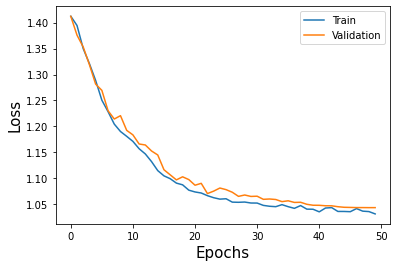

In [23]:
history = json.load(open('../checkpoint/history.json','r'))
plt.plot(range(len(history['train_loss'])), history['train_loss'])
plt.plot(range(len(history['val_loss'])), history['val_loss'])
plt.legend(['Train','Validation'], loc='upper right')
plt.ylabel('Loss', size=15)
plt.xlabel('Epochs', size=15)

In [24]:
weights = torch.load('../checkpoint/KinshipNet.pth')

net = ResNet18Kinship().to(device)
net.load_state_dict(weights['net'])
net.eval()

print('Load pretrained model')

Load pretrained model


# Quantity Evaluation

## Family Similarity and Non Family Similarity

In [25]:
class KinshipInferDataset(torch.utils.data.Dataset):
    def __init__(self, img_path, transform):
        self.p = img_path
        self.transform = transform
        
    def __len__(self):
        return len(self.p)
    
    def __getitem__(self, idx):
        
        # load image and convert RGB to grayscale
        p = Image.open(self.p[idx]).convert("L")
            
        # transform
        p = self.transform(p)
        
        return p

In [26]:
val_imgs_path = list(set(val_path['p1'].tolist() + val_path['p2'].tolist()))
val_imgs_path.sort()

In [27]:
inferset = KinshipInferDataset(img_path=val_imgs_path, transform=transform)
inferloader = torch.utils.data.DataLoader(inferset,
                                          batch_size=256,
                                          num_workers=8)

In [28]:
p_embed_list = []
with torch.no_grad():
    for batch_idx, p in enumerate(tqdm(inferloader, desc='Inference')):
        # inputs and targets
        p = p.to(device)

        # model output
        output = net
        (p.to(device))

        # distance
        p_embed_list.append(output.cpu().numpy())

p_embed = np.vstack(p_embed_list)

In [29]:
p_embed = inference(net, inferloader, device)

In [30]:
mat = np.einsum('ae,pe -> ap', p_embed, p_embed)

fam_list = [path.split('/')[-3] for path in val_imgs_path]
fam_list = pd.Series(fam_list).value_counts().sort_index()

sim_others = []
sim_fam = []
for i, fam_len1 in enumerate(fam_list):
    row_idx = 0
    col_idx = 0
    
    sim_others_i = []
    for j, fam_len2 in enumerate(fam_list):
        mat_fams = mat[row_idx:row_idx+fam_len1,col_idx:col_idx+fam_len2]
        if i==j:
            sim_fam.append((mat_fams.sum() - fam_len1)/((fam_len1 * fam_len2) - fam_len1))
        else:
            sim_others_i.append(mat_fams.mean())
        
    sim_others.append(sim_others_i)

In [54]:
sim_others = np.array(sim_others)
sim_fam = np.array(sim_fam)

In [75]:
pd.DataFrame([[sim_fam.mean(), sim_others.mean()],
              [sim_fam.std(), sim_others.std()]],
             columns=['Family','Others'],
             index=['Similarity (mean)','Similarity (std)'])

,Family,Others
Similarity (mean),0.634092,0.590786
Similarity (std),0.114868,0.088820


## Positive And Negative Similarity

In [66]:
sim_list = []
unsim_list = []
with torch.no_grad():
    for batch_idx, (anchors, positives, negatives) in enumerate(tqdm(valloader, desc='Validation')):
        # inputs
        anchors, positives, negatives = anchors.to(device), positives.to(device), negatives.to(device)

        # model output
        anchors_output = net(anchors)
        positives_output = net(positives)
        negatives_output = net(negatives)

        # distance
        sim_list.extend(torch.einsum('ae,pe -> ap', anchors_output, positives_output).diagonal().cpu().numpy())
        unsim_list.extend(torch.einsum('ae,pe -> ap', anchors_output, negatives_output).diagonal().cpu().numpy())

sim_list = np.vstack(sim_list)
unsim_list = np.vstack(unsim_list)

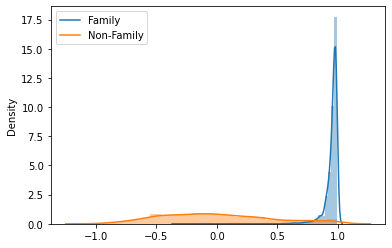

In [73]:
sns.distplot(sim_list.reshape(-1))
sns.distplot(unsim_list.reshape(-1))
plt.legend(['Family','Non-Family'])

# Quality Evaluation

![image](https://user-images.githubusercontent.com/37654013/122206095-f1833680-cedb-11eb-821d-9b86c05f97ec.png)

In [411]:
class GradCAM(object):
    '''
    Gradient Class Activation Map (Grad-CAM)
    '''
    def __init__(self, model, layer_name, device):
        # seqeuntial name
        self.layer_name = layer_name
        # model
        self.model = model
        self.device = device
        # evaluation mode
        self.model.eval()
        # hook
        self.hook_layers()
        # initial dicts
        self.conv_outputs = {}
        self.gradients = {}
    
    def hook_layers(self):
        def hook_forward(module, input, output, key):
            self.conv_outputs[key] = output

        def hook_backward(module, input, output, key):
            self.gradients[key] = output[0]

        for idx, layer in enumerate(self.model._modules.get(self.layer_name)):
            layer.register_forward_hook(partial(hook_forward, key=idx))
            layer.register_backward_hook(partial(hook_backward, key=idx))
            
    def generate_image(self, img_p1, img_p2, choice_p, idx, targets=None):    
        # prediction
        p1_outputs = self.model(img_p1)
        p2_outputs = self.model(img_p2)
        
        sim = torch.matmul(p1_outputs, p2_outputs.T)

        # convert target type to LongTensor
        targets = torch.LongTensor([targets]).to(device)
        
        if choice_p=='p1':
            outputs = self.model(img_p1)
        elif choice_p=='p2':
            outputs = self.model(img_p2)
            
        # p1 grad-cam
        self.model.zero_grad()
        
        one_hot_output = torch.zeros_like(sim).scatter(1, targets.unsqueeze(1), 1).detach()
        sim.backward(gradient=one_hot_output)

        gradients = self.gradients[idx].cpu().numpy()
        
        # A = w * conv_output
        convs = self.conv_outputs[idx].detach().cpu().numpy()
        weights = np.mean(gradients, axis=(2,3))
        weights = weights.reshape(weights.shape + (1,1,))

        gradcams = weights * convs
        gradcams = gradcams.sum(axis=1)

        # relu
        gradcams = np.maximum(gradcams, 0)
        
        return gradcams

def display_gradcam_with_image(img, heatmap, alpha=0.4):
    # Rescale 0~1 and Resize heatmap by the original image size
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())
    heatmap = cv2.resize(heatmap, dsize=(img.shape[1], img.shape[0]))
    
    # Use jet colormap to colorize heatmap
    heatmap = cv2.applyColorMap(np.uint8(heatmap * 255), cv2.COLORMAP_VIRIDIS)
    
    # Rescale heatmap and the original image range 0~1
    heatmap = np.float32(heatmap) / 255
    img = np.float32(img) / 255
    
    # Superimpose the heatmap on original image
    blend_img = heatmap * alpha + img
    blend_img = blend_img / blend_img.max()
    blend_img = np.uint8(blend_img*255)
    
    return blend_img

def vis_result(idx):
    ptype = val_path_info['ptype'][idx]
    kinship_dict = {
        'ss':'Sister - Sister',
        'bb':'Brother - Brother',
        'md':'Mother - Daughter',
        'fd':'Father - Daughter',
        'sibs':'Sister - Brother',
        'fs':'Father - Son',
        'ms':'Mother - Son',
        'gmgs':'Grandmother - Grandson',
        'gfgd':'Grandfather - Granddaughter',
        'gfgs':'Grandfather - Grandson',
        'gmgd':'Grandmother - Gransdaughter'
    }
    
    img1 = Image.open(val_path_info['p1_path'][idx])
    img2 = Image.open(val_path_info['p2_path'][idx])

    img1_input = transform(img1.convert('L')).unsqueeze(0)
    img2_input = transform(img2.convert('L')).unsqueeze(0)
    
    p1_gradcam = gradcam.generate_image(img_p1=img1_input.to(device),
                                        img_p2=img2_input.to(device),
                                        choice_p='p1',
                                        idx=0,
                                        targets=0)

    p2_gradcam = gradcam.generate_image(img_p1=img1_input.to(device),
                                        img_p2=img2_input.to(device),
                                        choice_p='p2',
                                        idx=0,
                                        targets=0)

    blend_p1_img = display_gradcam_with_image(img=np.array(img1),
                                              heatmap=np.squeeze(p1_gradcam,0),
                                              alpha=1)

    blend_p2_img = display_gradcam_with_image(img=np.array(img2),
                                              heatmap=np.squeeze(p2_gradcam,0),
                                              alpha=1)
    
    # plot
    fig, ax = plt.subplots(2, 1, figsize=(10,10))
    
    # original
    ax[0].imshow(np.hstack([np.array(img1),np.array(img2)]))
    ax[0].axis('off')
    ax[0].set_title(kinship_dict[ptype], size=20)
    
    # grad cam
    ax[1].imshow(np.hstack([blend_p1_img, blend_p2_img]))
    ax[1].axis('off')
    ax[1].set_title('Grad-CAM', size=20)

In [385]:
val_path_info = val_path.copy()

val_path_info.columns = ['p1_path','p2_path','FID']
val_path_info['p1'] = val_path_info.p1_path.apply(lambda x: '/'.join(x.split('/')[-3:-1]))
val_path_info['p2'] = val_path_info.p2_path.apply(lambda x: '/'.join(x.split('/')[-3:-1]))
val_path_info['p'] = val_path_info[['p1','p2']].apply(lambda x: '_'.join(x), axis=1)
train_info['p'] = train_info[['p1','p2']].apply(lambda x: '_'.join(x), axis=1)

val_path_info = pd.merge(val_path_info, train_info[['p','ptype']], on=['p'], how='inner')

In [141]:
gradcam = GradCAM(model=net, layer_name='layer4', device=device)

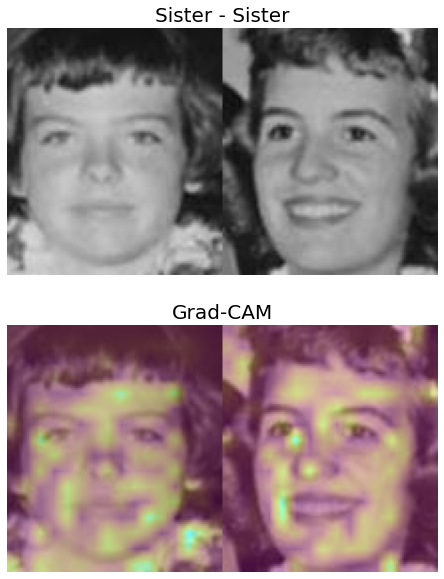

In [389]:
vis_result(10)

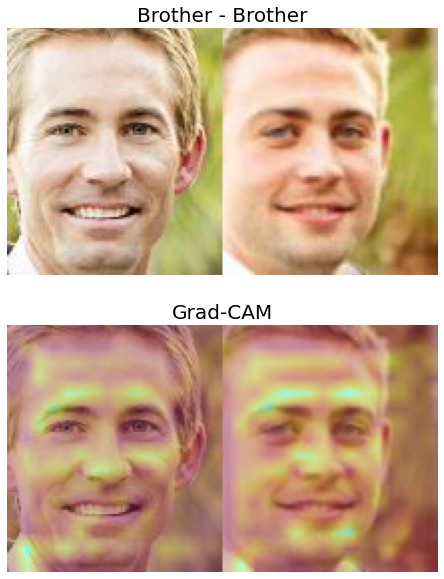

In [399]:
vis_result(32)

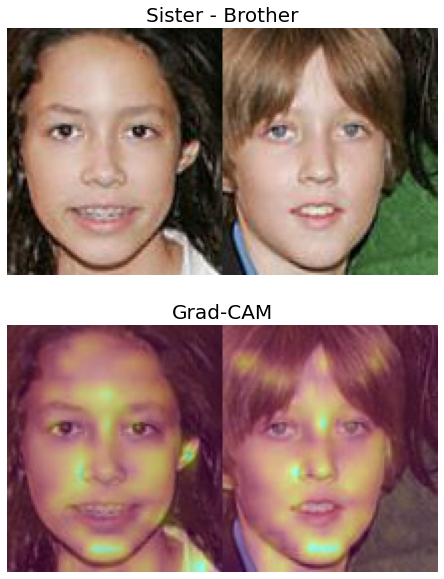

In [403]:
vis_result(92)

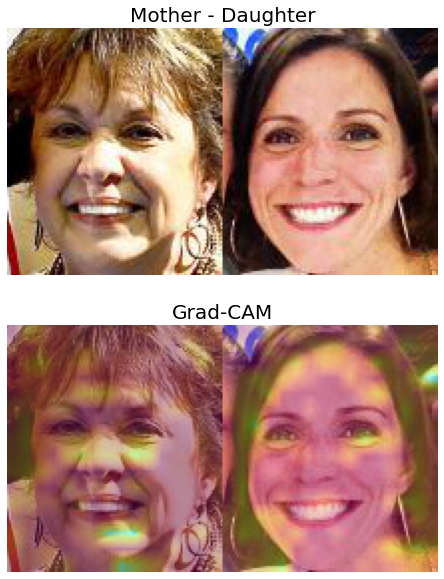

In [406]:
vis_result(1953)

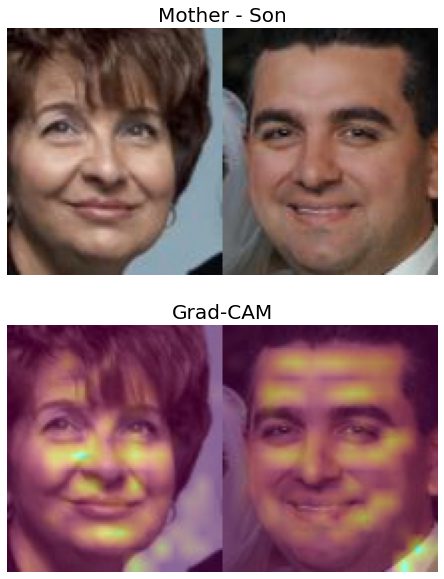

In [414]:
vis_result(2121)

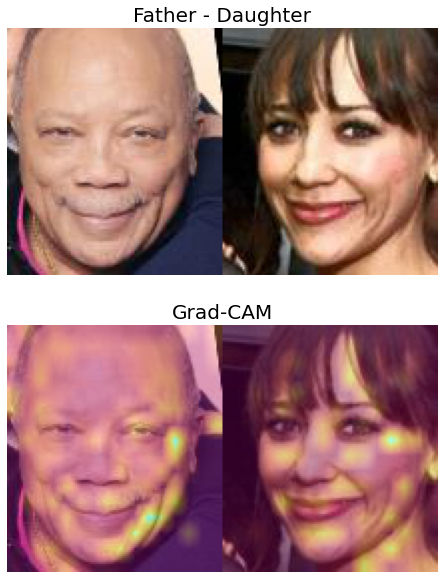

In [423]:
vis_result(3184)

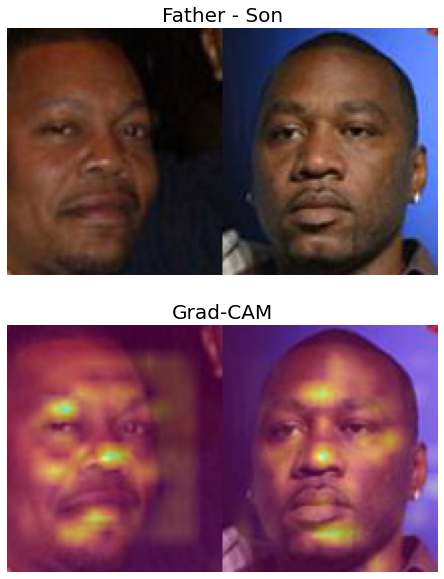

In [440]:
vis_result(5415)

# Family Example

In [126]:
daughter = Image.open('./data/train-faces/F0229/MID3/P02441_face0.jpg').convert('L')
mother = Image.open('./data/train-faces/F0229/MID2/P02439_face1.jpg').convert('L')
father = Image.open('./data/train-faces/F0229/MID1/P02436_face1.jpg').convert('L')

daughter_output = net(transform(daughter).unsqueeze(0).to(device))
mother_output = net(transform(mother).unsqueeze(0).to(device))
father_output = net(transform(father).unsqueeze(0).to(device))

md_sim = torch.matmul(mother_output, daughter_output.T)
fd_sim = torch.matmul(father_output, daughter_output.T)

print('Mother & Daughter Similarity: ',md_sim)
print('Father & Daughter Similarity: ',fd_sim)

Mother & Daughter Similarity:  tensor([[0.9583]], device='cuda:0', grad_fn=<MmBackward>)
Father & Daughter Similarity:  tensor([[0.9827]], device='cuda:0', grad_fn=<MmBackward>)


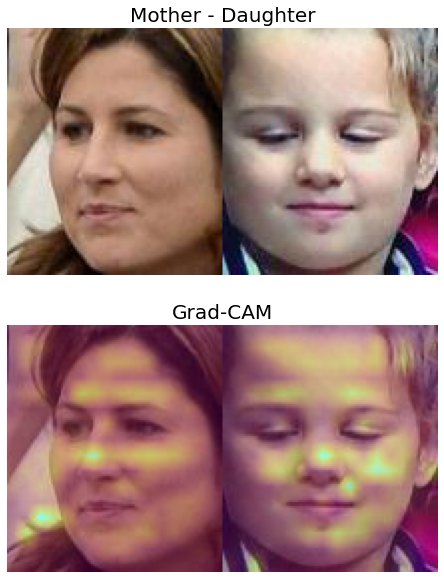

In [127]:
vis_result(18)

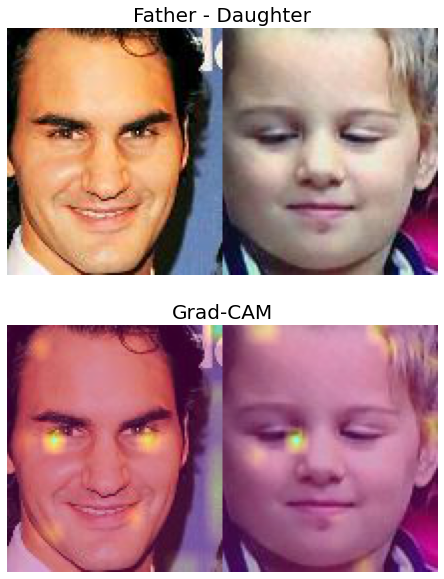

In [128]:
vis_result(1725)